In [84]:
import numpy as np



def pca(data : np.array) -> np.array:
    """
    Principal Component Analysis using SVD to reduce data to 2 dimensions.

    Parameters:
    -----------
    data (np.array): The input data array.

    Returns:
    --------
    np.array: The transformed 2D data array.
    """
    # Standardize the data (if necessary)
    data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

    # Compute the SVD
    U, S, V = np.linalg.svd(data, full_matrices=False)

    # The principal components are given by the right singular vectors
    # We only keep the first two for 2D data
    return V.T[:, :2]

In [85]:
def project_to_2d(data : np.array) -> np.array:
    """
    Project data onto a 2D basis.

    Parameters:
    -----------
    data (np.array): The input data array.

    Returns:
    --------
    np.array: The transformed 2D data array.
    """
    PCs = pca(data)
    return data @ PCs

In [86]:
import pandas as pd

data = pd.read_csv('../datasets/2D_data_points_1.txt', header=None).values

data_2d = data
if data.shape[1] > 2:
    data_2d = project_to_2d(data)

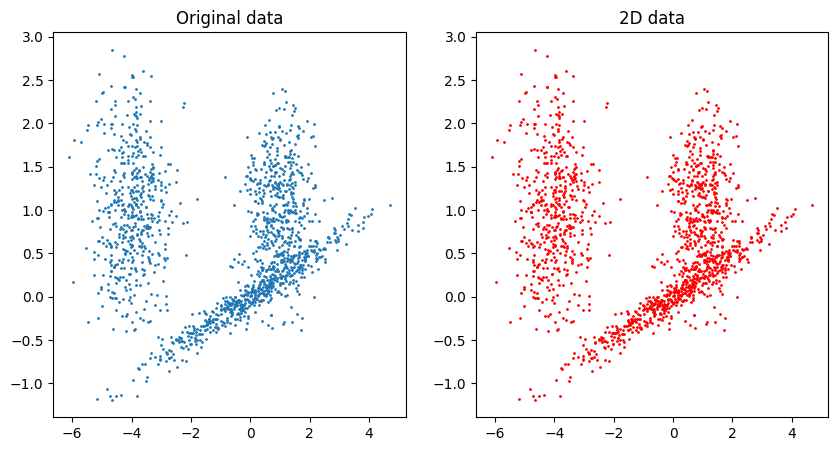

In [87]:
import matplotlib.pyplot as plt

# plot original and 2d data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(data[:, 0], data[:, 1], s=1)
ax1.set_title('Original data')
ax2.scatter(data_2d[:, 0], data_2d[:, 1], s=1, c = "red")
ax2.set_title('2D data')
plt.show()

In [88]:
class GaussianMixtureModel:
    def __init__(self, n_components=1, max_iter=100, tol=1e-4):
        """
        Parameters:
        -----------
        n_components (int): The number of mixture components.
        max_iter (int): The maximum number of iterations to perform.
        tol (float): The convergence threshold.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def _initialize_parameters(self, data: np.array) -> None:
        """
        Initialize the model parameters.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        # Initialize the weights
        self.weights = np.ones(self.n_components) / self.n_components

        # Initialize the means by sampling from the data
        random_rows = np.random.choice(data.shape[0], self.n_components)
        self.means = data[random_rows]

        # Initialize the covariance matrices as identity
        self.covs = np.array([np.eye(data.shape[1])] * self.n_components)

        # Initialize the log likelihood
        self.log_likelihood = 0.

    def _multivariate_gaussian(self, data: np.array, mu: np.array, cov: np.array) -> np.array:
        """
        Compute the multivariate Gaussian distribution.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        mu (np.array): The mean vector.
        cov (np.array): The covariance matrix.

        Returns:
        --------
        np.array: The probability density.
        """
        # Compute the determinant and inverse of the covariance matrix
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)

        # Compute the exponent
        exp = np.exp(-0.5 * np.sum((data - mu) @ inv * (data - mu), axis=1))

        # Compute the multivariate Gaussian
        return 1. / np.sqrt((2 * np.pi) ** data.shape[1] * det) * exp

    def _expectation(self, data: np.array) -> None:
        """
        The expectation step of the EM algorithm.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        # Compute the likelihoods of each component given the data
        likelihoods = np.array([self._multivariate_gaussian(data, mu, cov)
                                for mu, cov in zip(self.means, self.covs)
                            ])

        # Compute the responsibilities
        numerator = likelihoods * self.weights[:, np.newaxis]
        denominator = numerator.sum(axis=0)
        self.responsibilities = numerator / denominator

    def _maximization(self, data: np.array) -> None:
        """
        The maximization step of the EM algorithm.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        # Compute the total responsibility for each component
        responsibilities = self.responsibilities.sum(axis=1)

        # Update the weights
        self.weights = responsibilities / data.shape[0]

        # Update the means
        weighted_sum = self.responsibilities @ data
        self.means = weighted_sum / responsibilities[:, np.newaxis]

        # Update the covariance matrices
        for i in range(self.n_components):
            diff = data - self.means[i]
            weighted_sum = self.responsibilities[i] * diff.T @ diff
            self.covs[i] = weighted_sum / responsibilities[i] + np.eye(data.shape[1]) * 1e-6

    def _converged(self, data: np.array) -> bool:
        """
        Check for convergence.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.

        Returns:
        --------
        bool: Whether the model has converged.
        """
        # Compute the likelihoods of each component given the data
        likelihoods = np.array([self._multivariate_gaussian(data, mu, cov) for mu, cov in zip(self.means, self.covs)])

        # Compute the log likelihood
        log_likelihood = np.log(likelihoods.sum(axis=0)).sum()

        # Check for convergence
        if abs(log_likelihood - self.log_likelihood) < self.tol:
            return True

        # Update the log likelihood
        self.log_likelihood = log_likelihood

        return False

    def fit(self, data: np.array) -> None:
        """
        Fit a Gaussian mixture model to the data.

        Parameters:
        -----------
        data (np.array): The data to fit the model to.
        """
        # Initialize the parameters
        self._initialize_parameters(data)

        # Iterate until convergence or max iterations
        # for i in range(self.max_iter):
        while True:
            # E-step
            self._expectation(data)

            # M-step
            self._maximization(data)

            # Check for convergence
            if self._converged(data):
                break

In [89]:
from matplotlib.patches import Ellipse

def plot_gaussian_2d(mu: np.array, cov: np.array, ax: plt.Axes, n_std: float = 2.) -> None:
    """
    Plot a 2D Gaussian distribution.

    Parameters:
    -----------
    mu (np.array): The mean vector.
    cov (np.array): The covariance matrix.
    ax (plt.Axes): The matplotlib axes to plot on.
    n_std (float): The number of standard deviations to plot.
    """
    # Compute the standard deviations and rotation angle of the ellipse
    U, S, V = np.linalg.svd(cov)
    angle = np.arctan2(U[1, 0], U[0, 0])
    width, height = 2 * n_std * np.sqrt(S)

    # Plot the ellipse
    for ns in range(1, int(n_std) + 1):
        ax.add_patch(Ellipse(mu, ns * width, ns * height, angle=angle * 180. / np.pi, alpha=0.25 / ns))

    # Plot the mean
    ax.scatter(mu[0], mu[1], c='black', marker='+')

In [90]:
best_gmms = []
for k in range(3, 8):
    trials = 5
    best_gmm = None
    best_log_likelihood = -np.inf
    convergence_log_likelihoods = np.zeros(trials)

    for i in range(trials):
        gmm = GaussianMixtureModel(n_components=k, max_iter=1000)
        gmm.fit(data_2d)

        if gmm.log_likelihood > best_log_likelihood:
            best_log_likelihood = gmm.log_likelihood
            best_gmm = gmm
    
    best_gmms.append(best_gmm)

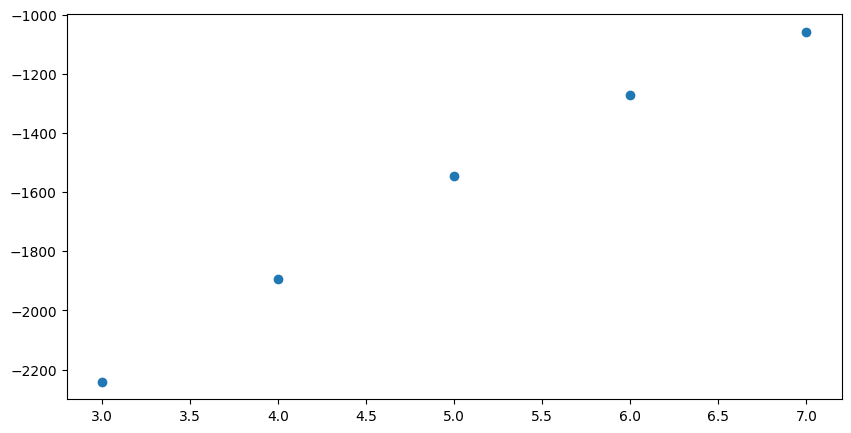

Clusters: 7
Log likelihood: -1057.2779795302686


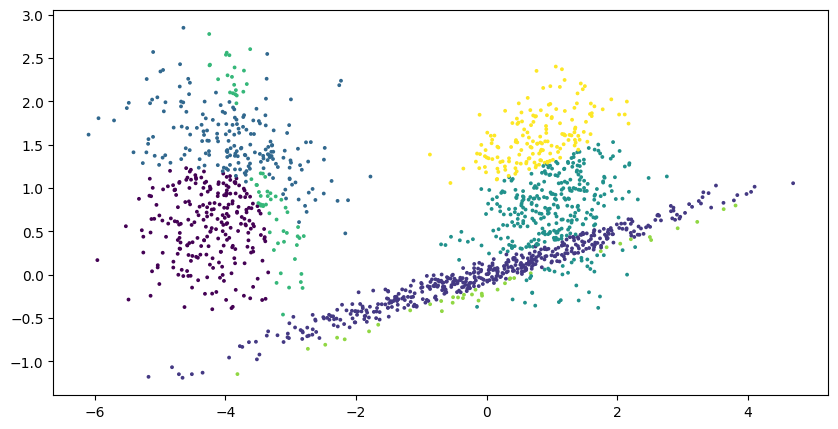

In [94]:
log_likelihoods = [best_gmm.log_likelihood for best_gmm in best_gmms]

plt.figure(figsize=(10, 5))
plt.scatter(range(3, 8), log_likelihoods)
plt.show()

# choose an appropriate value of K (denoted by K’) based on the convergence log-likelihood.
# plot the estimated GMM for K’ by showing sample data points and Gaussian distributions in a 2D plot.
best_gmm = best_gmms[np.argmax(log_likelihoods)]
print(f'Clusters: {best_gmm.n_components}')
print(f'Log likelihood: {best_gmm.log_likelihood}')

# flot the original data points colored by their cluster assignments
best_gmm._expectation(data_2d)
clusters = np.argmax(best_gmm.responsibilities, axis=0)

plt.figure(figsize=(10, 5))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters, s=3)
plt.show()
